# New CVID data

All samples (batch 1 + batch 2)

14.12.2020

This is a preprocessing notebook, so this happens here:

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:

- load
- filter genes, cells, add info
- perform **step 1** of calling doublets using Krzysztof's bertie doublet caller:
    - see bertie_doublet_caller.ipynb in /home/jovyan/ and read comments
- concatenate
- add doublet scores from saved tables (bertie)
- filter MT-high cells
- make cells (obs) and var (genes) unique
- parsing souporcell deconvolution results
- save preprocessed object

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [5]:
np.random.seed(0)

In [6]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.1
anndata             0.7.5
annoy               NA
attr                19.3.0
backcall            0.1.0
bbknn               NA
cffi                1.13.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.23
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.3.3
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.4
packaging           19.2
pandas              0.25.3
parso               0.5.1
pexpect             4.7.0
pickleshare         0.7.5
pkg_resou

In [7]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [8]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [9]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

### Reading and preprocessing

In [10]:
# sample ID GEX + sample ID CITE (coupled)
samples = [
           # batch 1 samples
           '35008_CV005_RV9039258_and_35008_CV005_RV9039282',
           '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
           '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
           '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
           '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
           '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
           '35008_CV005_RV9039264_and_35008_CV005_RV9039288',
           '35008_CV005_RV9039265_and_35008_CV005_RV9039289',
          
          # batch 2 samples
          '35171_CV005_RV9039361', # CV005_RV9039361 + CV005_RV9039386, unstim
          '35171_CV005_RV9039362', # CV005_RV9039362 + CV005_RV9039387, CD40L
          '35171_CV005_RV9039363', # CV005_RV9039363 + CV005_RV9039388, CD3
          '35171_CV005_RV9039364', # CV005_RV9039364 + CV005_RV9039389, BCR (a-IgM)
          ]


In [11]:
sample2activation = {}

sample2activation['35008_CV005_RV9039258_and_35008_CV005_RV9039282'] = 'unstim'
sample2activation['35008_CV005_RV9039259_and_35008_CV005_RV9039283'] = 'unstim'

sample2activation['35008_CV005_RV9039260_and_35008_CV005_RV9039284'] = 'CD40L'
sample2activation['35008_CV005_RV9039261_and_35008_CV005_RV9039285'] = 'CD40L'

sample2activation['35008_CV005_RV9039262_and_35008_CV005_RV9039286'] = 'CD3'
sample2activation['35008_CV005_RV9039263_and_35008_CV005_RV9039287'] = 'CD3'

sample2activation['35008_CV005_RV9039264_and_35008_CV005_RV9039288'] = 'BCR'
sample2activation['35008_CV005_RV9039265_and_35008_CV005_RV9039289'] = 'BCR'


sample2activation['35171_CV005_RV9039361'] = 'unstim'

sample2activation['35171_CV005_RV9039362'] = 'CD40L'

sample2activation['35171_CV005_RV9039363'] = 'CD3'

sample2activation['35171_CV005_RV9039364'] = 'BCR'


In [12]:
# to see how many cells cellranger called

holder = []

for sample in samples:
    print('sample', sample,
          "from scRNA-seq samples", list(samples).index(sample)+1,
          'out of', len(samples))
    
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    
    
    path_complete = path+'filtered_feature_bc_matrix.h5'
    holder.append(sc.read_10x_h5(path_complete,
                                gex_only=False))
    
    holder[-1].var_names_make_unique()
    

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

adata

sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282 from scRNA-seq samples 1 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039258_and_35008_CV005_RV9039282_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)
sample 35008_CV005_RV9039259_and_35008_CV005_RV9039283 from scRNA-seq samples 2 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039259_and_35008_CV005_RV9039283_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)
sample 35008_CV005_RV9039260_and_35008_CV005_RV9039284 from scRNA-seq samples 3 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039260_and_35008_CV005_RV9039284_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)
sample 35008_CV005_RV9039261_and_35008_CV005_RV9039285 from scRNA-seq samples 4 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039261_and_35008_CV005_RV9039285_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:06)
sample 35008_CV005_RV9039262_and_35008_CV005_RV9039286 from scRNA-seq samples 5 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039262_and_35008_CV005_RV9039286_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)
sample 35008_CV005_RV9039263_and_35008_CV005_RV9039287 from scRNA-seq samples 6 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039263_and_35008_CV005_RV9039287_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:05)
sample 35008_CV005_RV9039264_and_35008_CV005_RV9039288 from scRNA-seq samples 7 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039264_and_35008_CV005_RV9039288_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:06)
sample 35008_CV005_RV9039265_and_35008_CV005_RV9039289 from scRNA-seq samples 8 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039265_and_35008_CV005_RV9039289_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)
sample 35171_CV005_RV9039361 from scRNA-seq samples 9 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039361_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:10)
sample 35171_CV005_RV9039362 from scRNA-seq samples 10 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039362_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:14)
sample 35171_CV005_RV9039363 from scRNA-seq samples 11 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039363_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:16)
sample 35171_CV005_RV9039364 from scRNA-seq samples 12 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039364_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:11)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 255313 × 33886
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

This is happening in the cell below:
- read the raw file (output of cellranger)
- call doublets according to bertie doublet caller and adding all the scores
- Filter: 1) cells (< 500 genes); 2) genes (< 3 cells); 
- Add %mt genes
- Add relevant annotation info

In [36]:
%%time

holder = []

# for doublets
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
#os.makedirs('scrublet_scores')

for sample in samples:
    print('sample', sample,
          "from scRNA-seq samples", list(samples).index(sample)+1,
          'out of', len(samples))
    
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    
    
    path_complete = path+'filtered_feature_bc_matrix.h5'
    holder.append(sc.read_10x_h5(path_complete,
                                gex_only=False))
    
    holder[-1].var_names_make_unique()
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Adding donor information
    
    curr_info = sample2activation[sample]
    
    holder[-1].obs['stimulation'] = curr_info
    holder[-1].layers['counts'] = holder[-1].X.copy()
    #print('this was tissue block', block, 'sample:', sample)
    
    # Sample information
    holder[-1].obs['sample'] = sample
    # In cell_id we save barcode+sample index, to be unique in the future
    holder[-1].obs['cell_id'] = [i+'_'+j for i,j in zip(holder[-1].obs.index, holder[-1].obs['sample'])]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    holder[-1].obs['dataset'] = 'GEX+CITE-seq'
    holder[-1].obs['technique'] = '10X'
    
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    
    # for doublet detection we only consider GEX data
    curr_adata_GEX = holder[-1][:, holder[-1].var["feature_types"] == "Gene Expression"].copy()
    
    scores_table = bertie(curr_adata_GEX, sample)
    if list(scores_table.index) == list(curr_adata_GEX.obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta in scorenames:
            holder[-1].obs[meta] = scores_table[meta]
    else:
        print('indices in current bertie table and sample adata are NOT matching')

sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282 from scRNA-seq samples 1 out of 12
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039258_and_35008_CV005_RV9039282_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 16440 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/utils.py",

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 32 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 16099 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 32 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
filtered out 16665 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 15883 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 32 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 16473 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 17209 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 15912 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 36 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 1 cells that have less than 200 genes expressed
filtered out 16142 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 35 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
filtered out 14429 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 32 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 38 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
filtered out 13511 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 33 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 37 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)
filtered out 14110 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 34 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
filtered out 13952 genes that are detected in less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 31 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 38 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
  

# QC, cutoff decisions and reading again

In [24]:
%%time
# concatenate all samples into 1 object
# about 3 minutes
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 2.66 s, sys: 15.7 s, total: 18.3 s
Wall time: 18.4 s


In [25]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)  

In [26]:
# median of dtected genes
np.median(adata.obs['n_genes'])

1209.0

... storing 'stimulation' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


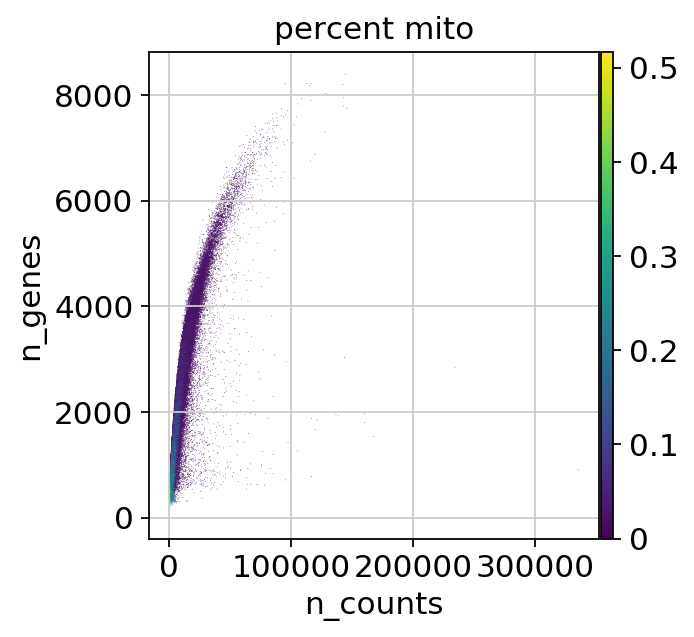

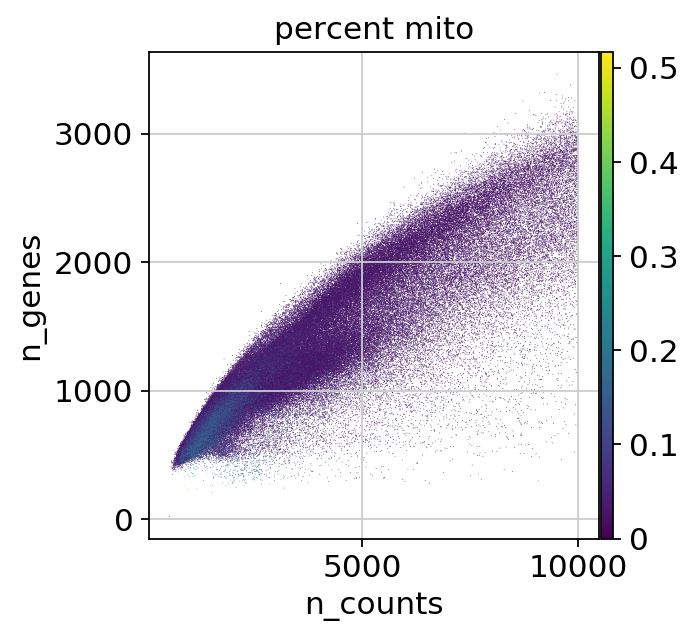

In [27]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


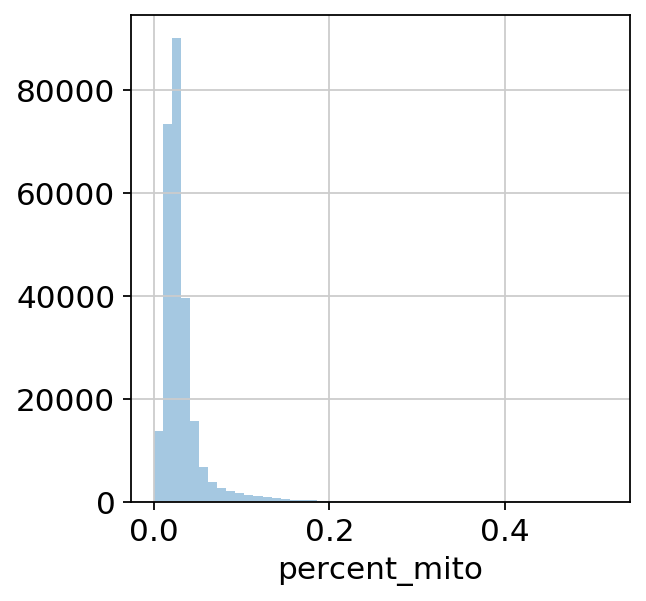

In [28]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [29]:
np.percentile(list(adata.obs['percent_mito']),20)

0.016866634041070937

In [30]:
len(adata[adata.obs['percent_mito'] > 0.2])

520

In [31]:
len(adata[adata.obs['percent_mito'] > 0.2])/len(adata.obs)

0.0020367157175701983

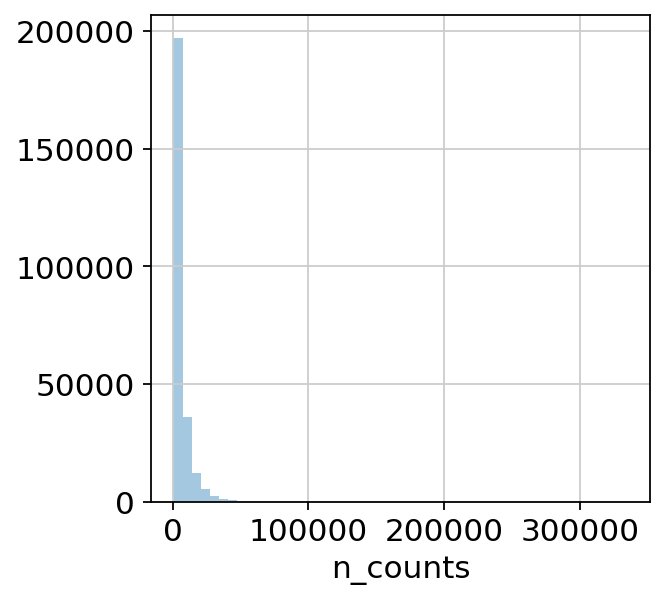

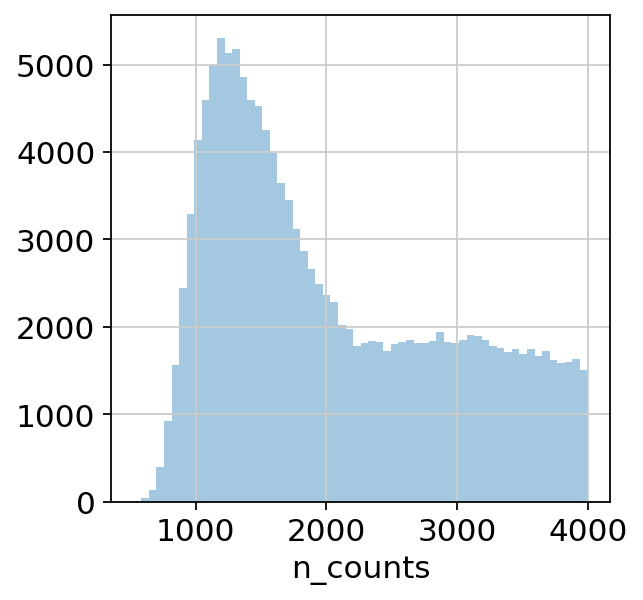

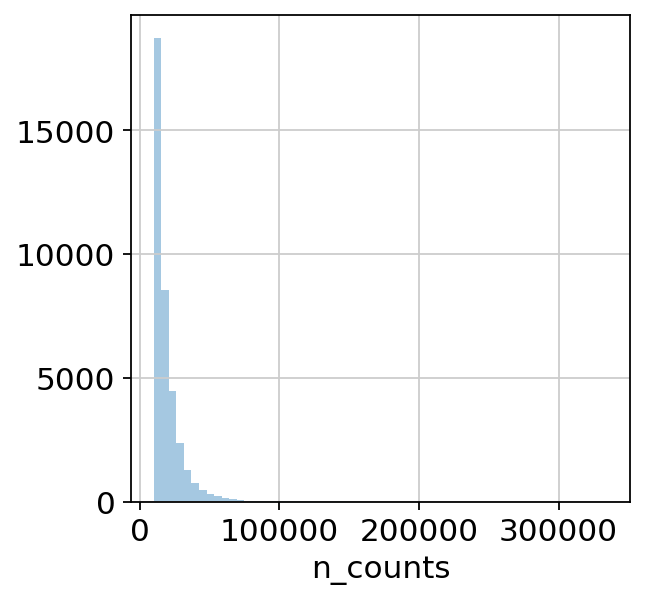

In [32]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


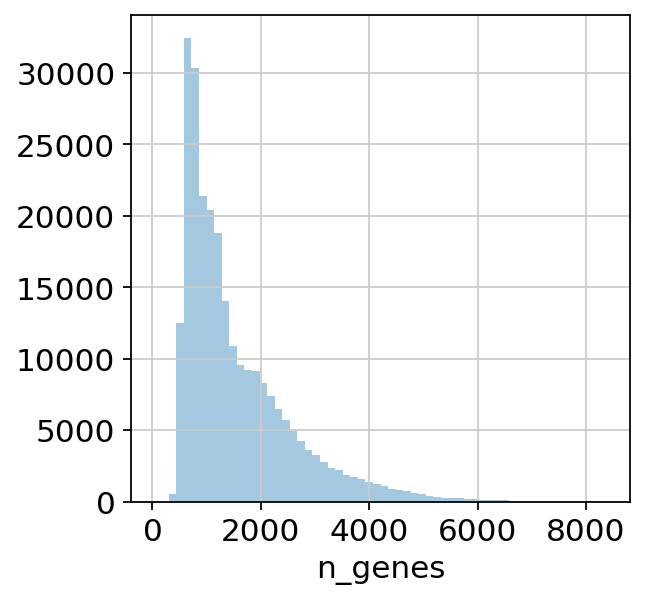

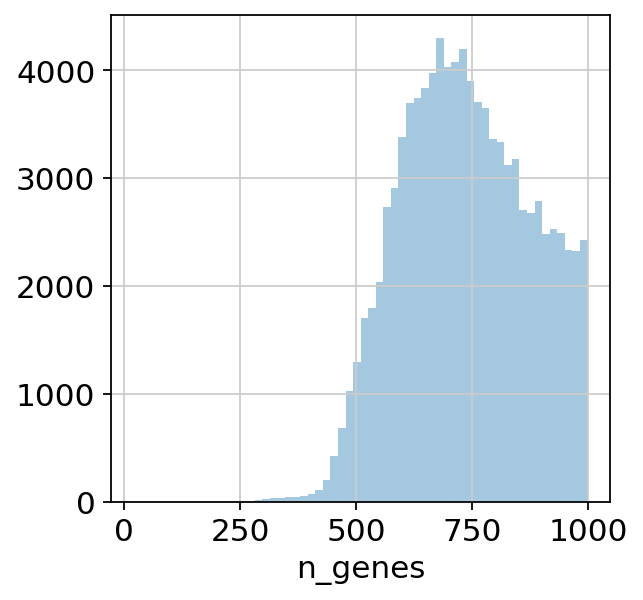

In [33]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up to reread and filter there

In [34]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35008_CV005_RV9039264_and_35008_CV005_RV9039288',
       '35008_CV005_RV9039265_and_35008_CV005_RV9039289',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363', '35171_CV005_RV9039364'], dtype=object)

In [35]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == '35008_CV005_RV9039258_and_35008_CV005_RV9039282'].X.todense()
np.unique(check)

matrix([[    0.,     0.,     0., ..., 32580., 35153., 36678.]],
       dtype=float32)

____________________________________________________________________________________________________________

Carrying on to:
- Concatenate

In [37]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 14.9 s, sys: 11 s, total: 25.9 s
Wall time: 25.9 s


Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [38]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata

adata.var_names_make_unique()
adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [39]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
# this parameter can be tweaked according to how harsh the detection needs to be
# the less it is, the less doublets it will call
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

In [40]:
adata

AnnData object with n_obs × n_vars = 254790 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'genome-9', 'n_cells-9'
    layers: 'counts'

In [41]:
adata.write(save_path+'adata_raw_filtered_all_samples.h5ad')

... storing 'stimulation' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'genome-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'genome-11' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'genome-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'genome-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'genom

In [42]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == '35008_CV005_RV9039258_and_35008_CV005_RV9039282'].X.todense()
np.unique(check)

matrix([[    0.,     0.,     0., ..., 32580., 35153., 36678.]],
       dtype=float32)

In [5]:
# reading
adata = sc.read(save_path+'adata_raw_filtered.h5ad')

In [6]:
adata.obs

,batch,bh_pval,cell_id,dataset,n_counts,n_genes,percent_mito,sample,scrublet_cluster_score,scrublet_score,stimulation,technique,is_doublet
index,,,,,,,,,,,,,
AAACCTGAGAATGTGT-1,0,0.831952,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,7290.0,2702,0.018107,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.121951,0.228916,unstim,10X,False
AAACCTGAGACTAAGT-1,0,0.851680,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,12742.0,3009,0.039083,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.103396,0.119403,unstim,10X,False
AAACCTGAGATCCCGC-1,0,0.796966,AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,801.0,509,0.031211,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.130053,0.071602,unstim,10X,False
AAACCTGAGCCGCCTA-1,0,0.851680,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1274.0,630,0.039246,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.101341,0.062818,unstim,10X,False
AAACCTGAGCGCCTCA-1,0,0.966599,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1137.0,629,0.028144,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.090028,0.107668,unstim,10X,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGATCCCT-1,7,0.926996,TTTGTCATCGATCCCT-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,974.0,597,0.024641,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.084559,0.078824,BCR,10X,False
TTTGTCATCGCTGATA-1,7,0.964333,TTTGTCATCGCTGATA-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,1867.0,818,0.022496,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.074814,0.050420,BCR,10X,False
TTTGTCATCGTCTGCT-1,7,0.926996,TTTGTCATCGTCTGCT-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,1418.0,792,0.031735,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.099391,0.119939,BCR,10X,False


# Producing a QC table

In [43]:
tables = {}

for sample in samples:
    print(sample)
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    tables[sample] = pd.read_csv(path + 'metrics_summary.csv')

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35008_CV005_RV9039264_and_35008_CV005_RV9039288
35008_CV005_RV9039265_and_35008_CV005_RV9039289
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363
35171_CV005_RV9039364


In [44]:
table_merged = pd.DataFrame(columns = list(tables.values())[0].columns,
                           index = samples)

In [45]:
for sample in samples:
    print(sample)
    table_merged.loc[sample,:] = list(tables[sample].loc[0,:])

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35008_CV005_RV9039264_and_35008_CV005_RV9039288
35008_CV005_RV9039265_and_35008_CV005_RV9039289
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363
35171_CV005_RV9039364


In [46]:
table_merged.to_csv('./QC_metrics_cellranger_all_samples.csv')

In [47]:
# number of cell called by cellranger
num_of_cells = [int(elem.split(',')[0]+elem.split(',')[1]) for elem in list(table_merged['Estimated Number of Cells'])]

In [48]:
num_of_cells

[17720,
 19435,
 12415,
 19832,
 22268,
 20522,
 19552,
 21186,
 21465,
 23553,
 29947,
 27418]

In [49]:
num_of_cells_total = np.sum(num_of_cells)

In [50]:
num_of_cells_total

255313